# 0. Import Packages

In [18]:
# on Docker/local
import sys
sys.path.append("../src")
sys.path.append("../DASstore") 
sys.path.append("/home/jmanos/notebooks/whidbey_noise")

import os
import time
from datetime import datetime, timedelta

import h5py
import numpy as np
import DAS_module
import matplotlib.pyplot as plt
from tqdm import tqdm
import dasquakes
from dasquakes import das_downloader

import importlib
importlib.reload(dasquakes)

import scipy
import scipy.signal
import seis_feature
import pandas as pd
import pickle

from scipy.signal import find_peaks
import math

from numpy.fft import fftshift, fft2, fftfreq

# 1.0 Get data and attributes from our date of interest

## 1.1 Initialize the wavespeed dataframe

In [ ]:
# Pandas dataframe to store the wave speeds

wavespeeds = pd.DataFrame(columns = ['Wavespeed', 'Time', 'Duration_min'])

## 1.2 Get attributes and change the date

In [138]:
task_t0 = datetime(2022, 12, 19, 2, 0, 0)

n_minute = 120
record_length = 1

cab = 'whidbey'
this_id = None
event_df = None

data, times, attrs, x_max, this_id, data_filt, t0 = das_downloader(event_df, this_id, cab, t0 = task_t0, record_length = 1)

/data/data6/whidbey/whidbey_2022-12-19_02-00*.h5


# 2.0 Assing the parameters we are using and pick the portion of cable we want (subsea)

In [139]:
#Assign the parameters
cha1, cha2 = 1150, 1550        #where to slice the cable

sps       = attrs['PulseRate']  # current sampling rate
samp_freq = 50                  # targeted sampling rate
freqmin   = 1                   # pre filtering frequency bandwidth
freqmax   = 20                  # note this cannot exceed Nquist freq

freq_norm   = 'rma'             # 'no' for no whitening, or 'rma' for running-mean average, 'phase_only' for sign-bit normalization in freq domain.
time_norm   = 'one_bit'         # 'no' for no normalization, or 'rma', 'one_bit' for normalization in time domain
cc_method   = 'xcorr'           # 'xcorr' for pure cross correlation, 'deconv' for deconvolution; FOR "COHERENCY" PLEASE set freq_norm to "rma", time_norm to "no" and cc_method to "xcorr"
smooth_N    = 100               # moving window length for time domain normalization if selected (points)
smoothspect_N  = 100            # moving window length to smooth spectrum amplitude (points)
maxlag      = 8                 # lags of cross-correlation to save (sec)

# criteria for data selection
max_over_std = 100              # threahold to remove window of bad signals: set it to 10*9 if prefer not to remove them

cc_len = 60                     # correlate length in second
step   = 60                     # stepping length in second

cha_list = np.array(range(cha1, cha2)) 
nsta = len(cha_list)
n_pair = int((nsta+1)*nsta/2)
n_lag = maxlag * samp_freq * 2 + 1

prepro_para = {'freqmin':freqmin,
               'freqmax':freqmax,
               'sps':sps,
               'npts_chunk':cc_len*sps,
               'nsta':nsta,
               'cha_list':cha_list,
               'samp_freq':samp_freq,
               'freq_norm':freq_norm,
               'time_norm':time_norm,
               'cc_method':cc_method,
               'smooth_N':smooth_N,
               'smoothspect_N':smoothspect_N,
               'maxlag':maxlag,
               'max_over_std':max_over_std}



# # you can save this parameter file to local
# metadata = os.path.join(CCFDIR, 'prepro_fft_info.txt')
# # output parameter info
# fout = open(metadata,'w')
# fout.write(str(prepro_para));fout.close()

# 3.0 One date of cross-correlations, we will eventually want to loop this

In [140]:
corr_full = np.zeros([n_lag, n_pair], dtype = np.float32)
stack_full = np.zeros([1, n_pair], dtype = np.int32)

# each task is one minute
pbar = tqdm(range(n_minute))
t_query = 0; t_compute = 0
for imin in pbar:
    t0 = time.time()
    pbar.set_description(f"Processing {task_t0}")
    task_t0 += timedelta(minutes = record_length)
    tdata, times, attrs, x_max, this_id, data_filt, t_dummy = das_downloader(None, 
                                                                       None, 
                                                                       cab, 
                                                                       t0 = task_t0, 
                                                                       record_length = record_length)
    
    
#     tdata = client.get_data(cha_list, 
#             starttime = task_t0,
#             endtime = task_t0 + timedelta(minutes = 1)).T
    t_query += time.time() - t0

    t1 = time.time()
    # perform pre-processing
    
    trace_stdS, dataS = DAS_module.preprocess_raw_make_stat(tdata[:,cha1:cha2], prepro_para)

    # do normalization if needed
    white_spect = DAS_module.noise_processing(dataS, prepro_para)
    Nfft = white_spect.shape[1]; Nfft2 = Nfft // 2
    data = white_spect[:, :Nfft2]
    del dataS, white_spect

    ind = np.where((trace_stdS < prepro_para['max_over_std']) &
                            (trace_stdS > 0) &
                    (np.isnan(trace_stdS) == 0))[0]
    if not len(ind):
        raise ValueError('the max_over_std criteria is too high which results in no data')
    sta = cha_list[ind]
    white_spect = data[ind]

    # loop over all stations
    for iiS in range(len(sta)):
        # smooth the source spectrum
        sfft1 = DAS_module.smooth_source_spect(white_spect[iiS], prepro_para)
        
        # correlate one source with all receivers
        corr, tindx = DAS_module.correlate(sfft1, white_spect[iiS:], prepro_para, Nfft)

        # update the receiver list
        tsta = sta[iiS:]
        receiver_lst = tsta[tindx]

        iS = int((cha2*2 - cha1 - sta[iiS] + 1) * (sta[iiS] - cha1) / 2)

        # stacking one minute
        corr_full[:, iS + receiver_lst - sta[iiS]] += corr.T
        stack_full[:, iS + receiver_lst - sta[iiS]] += 1
        
    t_compute += time.time() - t1
corr_full /= stack_full
print("%.3f seconds in data query, %.3f seconds in xcorr computing" % (t_query, t_compute))

Processing 2022-12-19 02:00:00:   0%|          | 0/120 [00:00<?, ?it/s]

/data/data6/whidbey/whidbey_2022-12-19_02-01*.h5


Processing 2022-12-19 02:01:00:   1%|          | 1/120 [00:09<19:16,  9.72s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-02*.h5


Processing 2022-12-19 02:02:00:   2%|▏         | 2/120 [00:19<19:09,  9.74s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-03*.h5


Processing 2022-12-19 02:03:00:   2%|▎         | 3/120 [00:29<19:22,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-04*.h5


Processing 2022-12-19 02:04:00:   3%|▎         | 4/120 [00:39<19:03,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-05*.h5


Processing 2022-12-19 02:05:00:   4%|▍         | 5/120 [00:49<19:06,  9.97s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-06*.h5


Processing 2022-12-19 02:06:00:   5%|▌         | 6/120 [00:59<18:48,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-07*.h5


Processing 2022-12-19 02:07:00:   6%|▌         | 7/120 [01:09<18:47,  9.98s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-08*.h5


Processing 2022-12-19 02:08:00:   7%|▋         | 8/120 [01:19<18:27,  9.89s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-09*.h5


Processing 2022-12-19 02:09:00:   8%|▊         | 9/120 [01:29<18:23,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-10*.h5


Processing 2022-12-19 02:10:00:   8%|▊         | 10/120 [01:38<18:05,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-11*.h5


Processing 2022-12-19 02:11:00:   9%|▉         | 11/120 [01:49<18:04,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-12*.h5


Processing 2022-12-19 02:12:00:  10%|█         | 12/120 [01:58<17:47,  9.88s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-13*.h5


Processing 2022-12-19 02:13:00:  11%|█         | 13/120 [02:08<17:43,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-14*.h5


Processing 2022-12-19 02:14:00:  12%|█▏        | 14/120 [02:18<17:29,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-15*.h5


Processing 2022-12-19 02:15:00:  12%|█▎        | 15/120 [02:28<17:29, 10.00s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-16*.h5


Processing 2022-12-19 02:16:00:  13%|█▎        | 16/120 [02:38<17:08,  9.89s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-17*.h5


Processing 2022-12-19 02:17:00:  14%|█▍        | 17/120 [02:48<17:04,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-18*.h5


Processing 2022-12-19 02:18:00:  15%|█▌        | 18/120 [02:58<16:50,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-19*.h5


Processing 2022-12-19 02:19:00:  16%|█▌        | 19/120 [03:08<16:46,  9.96s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-20*.h5


Processing 2022-12-19 02:20:00:  17%|█▋        | 20/120 [03:18<16:28,  9.88s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-21*.h5


Processing 2022-12-19 02:21:00:  18%|█▊        | 21/120 [03:28<16:24,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-22*.h5


Processing 2022-12-19 02:22:00:  18%|█▊        | 22/120 [03:37<16:05,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-23*.h5


Processing 2022-12-19 02:23:00:  19%|█▉        | 23/120 [03:47<16:01,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-24*.h5


Processing 2022-12-19 02:24:00:  20%|██        | 24/120 [03:57<15:44,  9.84s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-25*.h5


Processing 2022-12-19 02:25:00:  21%|██        | 25/120 [04:07<15:42,  9.92s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-26*.h5


Processing 2022-12-19 02:26:00:  22%|██▏       | 26/120 [04:17<15:27,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-27*.h5


Processing 2022-12-19 02:27:00:  22%|██▎       | 27/120 [04:27<15:24,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-28*.h5


Processing 2022-12-19 02:28:00:  23%|██▎       | 28/120 [04:37<15:11,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-29*.h5


Processing 2022-12-19 02:29:00:  24%|██▍       | 29/120 [04:47<15:07,  9.97s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-30*.h5


Processing 2022-12-19 02:30:00:  25%|██▌       | 30/120 [04:57<14:50,  9.89s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-31*.h5


Processing 2022-12-19 02:31:00:  26%|██▌       | 31/120 [05:07<14:45,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-32*.h5


Processing 2022-12-19 02:32:00:  27%|██▋       | 32/120 [05:17<14:29,  9.88s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-33*.h5


Processing 2022-12-19 02:33:00:  28%|██▊       | 33/120 [05:27<14:25,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-34*.h5


Processing 2022-12-19 02:34:00:  28%|██▊       | 34/120 [05:37<14:12,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-35*.h5


Processing 2022-12-19 02:35:00:  29%|██▉       | 35/120 [05:47<14:07,  9.98s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-36*.h5


Processing 2022-12-19 02:36:00:  30%|███       | 36/120 [05:56<13:52,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-37*.h5


Processing 2022-12-19 02:37:00:  31%|███       | 37/120 [06:07<13:48,  9.98s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-38*.h5


Processing 2022-12-19 02:38:00:  32%|███▏      | 38/120 [06:16<13:32,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-39*.h5


Processing 2022-12-19 02:39:00:  32%|███▎      | 39/120 [06:26<13:27,  9.97s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-40*.h5


Processing 2022-12-19 02:40:00:  33%|███▎      | 40/120 [06:36<13:12,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-41*.h5


Processing 2022-12-19 02:41:00:  34%|███▍      | 41/120 [06:46<13:08,  9.99s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-42*.h5


Processing 2022-12-19 02:42:00:  35%|███▌      | 42/120 [06:56<12:52,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-43*.h5


Processing 2022-12-19 02:43:00:  36%|███▌      | 43/120 [07:06<12:45,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-44*.h5


Processing 2022-12-19 02:44:00:  37%|███▋      | 44/120 [07:16<12:29,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-45*.h5


Processing 2022-12-19 02:45:00:  38%|███▊      | 45/120 [07:26<12:24,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-46*.h5


Processing 2022-12-19 02:46:00:  38%|███▊      | 46/120 [07:36<12:09,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-47*.h5


Processing 2022-12-19 02:47:00:  39%|███▉      | 47/120 [07:46<12:06,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-48*.h5


Processing 2022-12-19 02:48:00:  40%|████      | 48/120 [07:55<11:49,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-49*.h5


Processing 2022-12-19 02:49:00:  41%|████      | 49/120 [08:05<11:45,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-50*.h5


Processing 2022-12-19 02:50:00:  42%|████▏     | 50/120 [08:15<11:30,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-51*.h5


Processing 2022-12-19 02:51:00:  42%|████▎     | 51/120 [08:25<11:25,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-52*.h5


Processing 2022-12-19 02:52:00:  43%|████▎     | 52/120 [08:35<11:09,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-53*.h5


Processing 2022-12-19 02:53:00:  44%|████▍     | 53/120 [08:45<11:04,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-54*.h5


Processing 2022-12-19 02:54:00:  45%|████▌     | 54/120 [08:55<10:48,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-55*.h5


Processing 2022-12-19 02:55:00:  46%|████▌     | 55/120 [09:05<10:44,  9.91s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-56*.h5


Processing 2022-12-19 02:56:00:  47%|████▋     | 56/120 [09:14<10:29,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-57*.h5


Processing 2022-12-19 02:57:00:  48%|████▊     | 57/120 [09:24<10:25,  9.92s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-58*.h5


Processing 2022-12-19 02:58:00:  48%|████▊     | 58/120 [09:34<10:09,  9.84s/it]

/data/data6/whidbey/whidbey_2022-12-19_02-59*.h5


Processing 2022-12-19 02:59:00:  49%|████▉     | 59/120 [09:44<10:08,  9.98s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-00*.h5


Processing 2022-12-19 03:00:00:  50%|█████     | 60/120 [09:54<09:56,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-01*.h5


Processing 2022-12-19 03:01:00:  51%|█████     | 61/120 [10:05<09:52, 10.05s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-02*.h5


Processing 2022-12-19 03:02:00:  52%|█████▏    | 62/120 [10:14<09:36,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-03*.h5


Processing 2022-12-19 03:03:00:  52%|█████▎    | 63/120 [10:24<09:31, 10.02s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-04*.h5


Processing 2022-12-19 03:04:00:  53%|█████▎    | 64/120 [10:34<09:16,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-05*.h5


Processing 2022-12-19 03:05:00:  54%|█████▍    | 65/120 [10:44<09:09,  9.99s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-06*.h5


Processing 2022-12-19 03:06:00:  55%|█████▌    | 66/120 [10:54<08:54,  9.89s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-07*.h5


Processing 2022-12-19 03:07:00:  56%|█████▌    | 67/120 [11:04<08:46,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-08*.h5


Processing 2022-12-19 03:08:00:  57%|█████▋    | 68/120 [11:14<08:32,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-09*.h5


Processing 2022-12-19 03:09:00:  57%|█████▊    | 69/120 [11:24<08:25,  9.92s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-10*.h5


Processing 2022-12-19 03:10:00:  58%|█████▊    | 70/120 [11:34<08:13,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-11*.h5


Processing 2022-12-19 03:11:00:  59%|█████▉    | 71/120 [11:44<08:06,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-12*.h5


Processing 2022-12-19 03:12:00:  60%|██████    | 72/120 [11:53<07:53,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-13*.h5


Processing 2022-12-19 03:13:00:  61%|██████    | 73/120 [12:03<07:47,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-14*.h5


Processing 2022-12-19 03:14:00:  62%|██████▏   | 74/120 [12:13<07:34,  9.88s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-15*.h5


Processing 2022-12-19 03:15:00:  62%|██████▎   | 75/120 [12:23<07:27,  9.95s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-16*.h5


Processing 2022-12-19 03:16:00:  63%|██████▎   | 76/120 [12:33<07:14,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-17*.h5


Processing 2022-12-19 03:17:00:  64%|██████▍   | 77/120 [12:43<07:08,  9.96s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-18*.h5


Processing 2022-12-19 03:18:00:  65%|██████▌   | 78/120 [12:53<06:54,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-19*.h5


Processing 2022-12-19 03:19:00:  66%|██████▌   | 79/120 [13:03<06:47,  9.94s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-20*.h5


Processing 2022-12-19 03:20:00:  67%|██████▋   | 80/120 [13:13<06:34,  9.87s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-21*.h5


Processing 2022-12-19 03:21:00:  68%|██████▊   | 81/120 [13:23<06:27,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-22*.h5


Processing 2022-12-19 03:22:00:  68%|██████▊   | 82/120 [13:32<06:13,  9.83s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-23*.h5


Processing 2022-12-19 03:23:00:  69%|██████▉   | 83/120 [13:42<06:06,  9.89s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-24*.h5


Processing 2022-12-19 03:24:00:  70%|███████   | 84/120 [13:52<05:54,  9.85s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-25*.h5


Processing 2022-12-19 03:25:00:  71%|███████   | 85/120 [14:02<05:47,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-26*.h5


Processing 2022-12-19 03:26:00:  72%|███████▏  | 86/120 [14:12<05:34,  9.84s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-27*.h5


Processing 2022-12-19 03:27:00:  72%|███████▎  | 87/120 [14:22<05:27,  9.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-28*.h5


Processing 2022-12-19 03:28:00:  73%|███████▎  | 88/120 [14:32<05:15,  9.86s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-29*.h5


Processing 2022-12-19 03:29:00:  74%|███████▍  | 89/120 [14:42<05:09, 10.00s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-30*.h5


Processing 2022-12-19 03:30:00:  75%|███████▌  | 90/120 [14:52<04:57,  9.90s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-31*.h5


Processing 2022-12-19 03:31:00:  76%|███████▌  | 91/120 [15:02<04:52, 10.09s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-32*.h5


Processing 2022-12-19 03:32:00:  77%|███████▋  | 92/120 [15:13<04:48, 10.31s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-33*.h5


Processing 2022-12-19 03:33:00:  78%|███████▊  | 93/120 [15:24<04:47, 10.64s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-34*.h5


Processing 2022-12-19 03:34:00:  78%|███████▊  | 94/120 [15:35<04:36, 10.64s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-35*.h5


Processing 2022-12-19 03:35:00:  79%|███████▉  | 95/120 [15:46<04:29, 10.80s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-36*.h5


Processing 2022-12-19 03:36:00:  80%|████████  | 96/120 [15:57<04:16, 10.69s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-37*.h5


Processing 2022-12-19 03:37:00:  81%|████████  | 97/120 [16:07<04:02, 10.55s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-38*.h5


Processing 2022-12-19 03:38:00:  82%|████████▏ | 98/120 [16:17<03:46, 10.31s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-39*.h5


Processing 2022-12-19 03:39:00:  82%|████████▎ | 99/120 [16:27<03:36, 10.29s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-40*.h5


Processing 2022-12-19 03:40:00:  83%|████████▎ | 100/120 [16:37<03:23, 10.17s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-41*.h5


Processing 2022-12-19 03:41:00:  84%|████████▍ | 101/120 [16:47<03:13, 10.20s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-42*.h5


Processing 2022-12-19 03:42:00:  85%|████████▌ | 102/120 [16:57<03:01, 10.07s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-43*.h5


Processing 2022-12-19 03:43:00:  86%|████████▌ | 103/120 [17:07<02:51, 10.10s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-44*.h5


Processing 2022-12-19 03:44:00:  87%|████████▋ | 104/120 [17:17<02:42, 10.17s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-45*.h5


Processing 2022-12-19 03:45:00:  88%|████████▊ | 105/120 [17:29<02:37, 10.50s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-46*.h5


Processing 2022-12-19 03:46:00:  88%|████████▊ | 106/120 [17:39<02:27, 10.56s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-47*.h5


Processing 2022-12-19 03:47:00:  89%|████████▉ | 107/120 [17:50<02:18, 10.67s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-48*.h5


Processing 2022-12-19 03:48:00:  90%|█████████ | 108/120 [18:00<02:04, 10.40s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-49*.h5


Processing 2022-12-19 03:49:00:  91%|█████████ | 109/120 [18:10<01:53, 10.34s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-50*.h5


Processing 2022-12-19 03:50:00:  92%|█████████▏| 110/120 [18:21<01:44, 10.50s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-51*.h5


Processing 2022-12-19 03:51:00:  92%|█████████▎| 111/120 [18:32<01:36, 10.75s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-52*.h5


Processing 2022-12-19 03:52:00:  93%|█████████▎| 112/120 [18:43<01:25, 10.72s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-53*.h5


Processing 2022-12-19 03:53:00:  94%|█████████▍| 113/120 [18:53<01:13, 10.55s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-54*.h5


Processing 2022-12-19 03:54:00:  95%|█████████▌| 114/120 [19:03<01:01, 10.30s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-55*.h5


Processing 2022-12-19 03:55:00:  96%|█████████▌| 115/120 [19:14<00:52, 10.50s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-56*.h5


Processing 2022-12-19 03:56:00:  97%|█████████▋| 116/120 [19:25<00:42, 10.65s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-57*.h5


Processing 2022-12-19 03:57:00:  98%|█████████▊| 117/120 [19:36<00:32, 10.84s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-58*.h5


Processing 2022-12-19 03:58:00:  98%|█████████▊| 118/120 [19:47<00:21, 10.84s/it]

/data/data6/whidbey/whidbey_2022-12-19_03-59*.h5


Processing 2022-12-19 03:59:00:  99%|█████████▉| 119/120 [19:58<00:10, 10.93s/it]

/data/data6/whidbey/whidbey_2022-12-19_04-00*.h5


Processing 2022-12-19 03:59:00: 100%|██████████| 120/120 [20:08<00:00, 10.07s/it]

191.966 seconds in data query, 1016.607 seconds in xcorr computing


# 4.0 Do the FFT and stack the FK plot 

In [141]:
all_ffts = []

for i in range(nsta):
    vsg = np.zeros([801, nsta])
    source_step = i
    for i in range(source_step):
        chan_source = i + cha1
        iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
        vsg[:, i] = corr_full[:, iS + (source_step - i)][::-1]

    chan_source = cha1 + source_step
    iS =  int((cha2*2 - cha1 - chan_source + 1) * (chan_source - cha1) / 2)
    iS2 =  int((cha2*2 - cha1 - (chan_source+1) + 1) * ((chan_source+1) - cha1) / 2)
    vsg[:, source_step:] = corr_full[:, iS:iS2]
    source_step = i


    ft = fftshift(fft2(vsg.T))
    f = fftshift(fftfreq(vsg.T.shape[0], d=1/samp_freq))
    k = fftshift(fftfreq(vsg.T.shape[1], d=attrs['SpatialSamplingInterval']))
#     print(ft.shape)
    all_ffts.append(np.log10(np.abs(ft)))
    
d3_matrix = np.asarray(all_ffts)
stacked = np.mean(d3_matrix, axis=0)

### 4.1 Save the stacked FK-plot

In [142]:
# Save the stacked image
# Get the start file time
file_start_time = task_t0 - timedelta(minutes=n_minute)
# Open a file and use dump()
with open('../data/stacked_fk/fk_array_'+str(file_start_time)+'_'+str(task_t0)+'.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(stacked, file)

# 5.0 Calculate the velocity on the FK-plot

In [143]:
#Slicing to get the top right quadrant

stacked_rows = stacked.shape[0]
stacked_cols = stacked.shape[1]

frow = f[int(stacked_rows*0.5):]
kcol = k[int(stacked_cols*0.6):int(stacked_cols*0.7)]

tr_quad = stacked[int(stacked_rows*0.5):,int(stacked_cols*0.6):int(stacked_cols*0.7)]

#Apply a Gaussian smoothing
gauss_filt = scipy.ndimage.gaussian_filter(tr_quad, 1)

In [145]:
peaks = np.zeros((len(kcol)))

for i in range(len(kcol)):
    peak_loc, properties = find_peaks(gauss_filt[:,i], prominence=.1)

    if not peak_loc:
        peaks[i] = np.nan
    else:
        peaks[i] = peak_loc

        

f_peaks = np.zeros((len(kcol)))  

for i, j in enumerate(np.asarray(peaks)):
        if math.isnan(j):
            f_peaks[i] = np.nan
        else:
            f_peaks[i] = frow[int(j)]

idx = np.isfinite(kcol) & np.isfinite(f_peaks)
ab = np.polyfit(kcol[idx], f_peaks[idx], 1)

wave_speed = ab[0] * attrs['SpatialSamplingInterval']

/home/jmanos/miniconda3/envs/comcat/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  


# 6.0 Append pandas dataframe to store the wavespeeds

In [147]:
data_for_dataframe = {'Wavespeed': [wave_speed], 'Time':[str(file_start_time)], 'Duration_min':[n_minute]}

to_append = pd.DataFrame(data_for_dataframe)
wavespeeds = pd.concat([wavespeeds, to_append], ignore_index=True)
wavespeeds

,Wavespeed,Time,Duration_min
0,282.954680,2022-12-01 02:00:00,120
1,203.837255,2022-12-08 02:00:00,120
2,178.363647,2022-12-15 02:00:00,120
3,196.378208,2022-12-22 02:00:00,120
4,198.542781,2022-12-29 02:00:00,120
5,265.942016,2022-12-02 02:00:00,120
6,241.136146,2022-12-03 02:00:00,120
7,245.701276,2022-12-19 02:00:00,120


### 6.1 plot the individual wavespeed to investigate peak finder

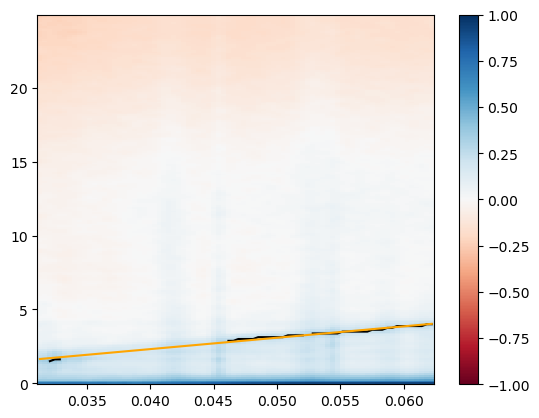

In [146]:
fig, ax = plt.subplots()

c = ax.pcolormesh(kcol,frow,gauss_filt,vmin=-1,vmax = 1, cmap='RdBu')
plt.colorbar(c)
ax.plot(kcol, f_peaks, color='black')
ax.plot(kcol,kcol*ab[0]+ab[-1], color='orange')
# ax.set_ylim([0,2])
# ax.set_xlim([0.006,.03])
plt.show()

### 6.2 plot all wavespeeds in time

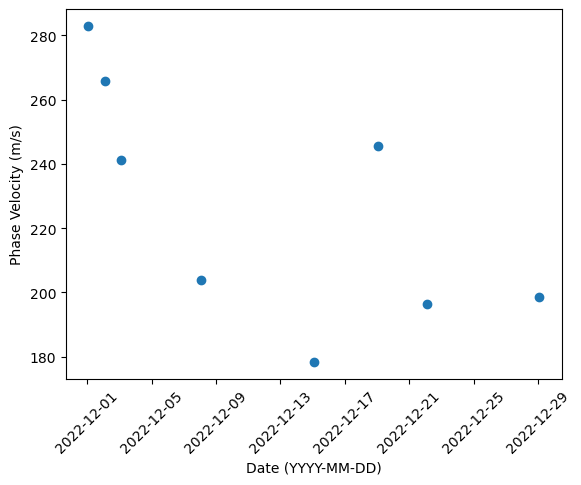

In [152]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
dates = mdates.date2num(wavespeeds['Time'])
ax.scatter(dates, wavespeeds['Wavespeed'])
ax.xaxis_date()
plt.xticks(rotation=45)
ax.set_ylabel('Phase Velocity (m/s)')
ax.set_xlabel('Date (YYYY-MM-DD)')
plt.show()